# Introduction

We construct a toy investment strategy from 11 of the largest stocks from 11 of the the different sectors in the S&P500. We calculate the sharpe ratio of that on the out of sample data. We also calculate a distribution of sharpe ratios on a monte carlo simulation of out of sample prices, generated from the true out-of sample prices. We use this to calculate the mean sharpe ratio, variance of sharpe ratios and the deflated sharpe ratio. We compare the toy investment strategy to a baseline. In this case, we take our baseline as a simple but and hold strategy. We use the Hierarcical Risk Parity method to construct the optimal portfolio from our stocks at the beginning of the buy and hold strategy. We also use this method of portfolio optimisation for rebalancing in the toy investment strategy.

List of TOP 11 stocks in SP500 for each sector

- AAPL - Technology
- AMZN - Consumer discretionary
- GOOGL - Communication Services
- Berkshire Hathway (BRK.B) BRK-B  - Financials
- United Health Group (UNH) - healthcare
- Exxon (XOM) - Energy
- Walmart (WMT) - Consumer Staples
- Linde Plc (LIN) - Materials
- UPS - Industrials
- Nextera energy (NEE) - Utilities
- Prologis Inc (PLD) - Real Estate 

# Data Loading

We have 10 years of daily stock prices data in total for each individual stock from Yahoo finance. We keep one year of the most recent stock prices as complete out of sample data for testing. We also keep an additional month of purged data to ensure there is no data leakage from training and validation into testing. This is because we use a maximum 26 day moving average to construct one of our features. For training we will use a fixed 7 year training window and 10 walkforward cross validation timesteps using the 8 years 10 months data. By default, we begin by examining the distribution and stationarity of the features constructed from the training + validation data. We also ensure there is no data leakage between training and validation during hperparameter tuning by creating a custom function to purge and embargo any data between the datasets.

## Limitations on Data

Here we are using time weighted daily bars for our investment model. Ideally we might more granular tick by tick data and experiment with different types of bars constructed from them. Volume bars and dollar bars are shown to be more stable and representative of market activity

In [1]:
import yfinance as yf
from datetime import datetime, timedelta

START_DATE = '2013-7-15'
END_DATE = '2023-7-15'

def load_data(ticker_symbol: str):
    #define the ticker symbol

    #get data on this ticker
    tickerData = yf.Ticker(ticker_symbol)

    #get the historical prices for this ticker
    tickerDf = tickerData.history(interval='1d', start=START_DATE, end=END_DATE)
    split_date = tickerDf.index[-1] - timedelta(days=425)
    train_validation_data = tickerDf[tickerDf.index < split_date]
    test_data = tickerDf[tickerDf.index > split_date]
    return train_validation_data, test_data, tickerDf, split_date

stocks_list = ["AAPL", "AMZN", "GOOGL", "BRK-B", "UNH", "XOM", "WMT", "LIN", "UPS", "NEE", "PLD"]
stocks_data = {stock: load_data(stock)[0] for stock in stocks_list}
stocks_test_data = {stock: load_data(stock)[1] for stock in stocks_list}
stocks_train_test_data = {stock: load_data(stock)[2] for stock in stocks_list}
split_date = load_data("AAPL")[3]
train_size = stocks_data["AAPL"].shape[0]
test_size = stocks_test_data["AAPL"].shape[0]
full_data_size = stocks_train_test_data["AAPL"].shape[0]

print("Start date:", START_DATE)
print("End Date:", END_DATE)
print("split_date:", split_date)
print("Train size:", train_size)
print("Test size:", test_size)
print("Full_data size:", full_data_size)

Start date: 2013-7-15
End Date: 2023-7-15
split_date: 2022-05-15 00:00:00-04:00
Train size: 2226
Test size: 292
Full_data size: 2518


# Labeling

For the investment strategy, we could have treated this as a time series forecasting problem where we forecast the returns with a certain confidence interval or band. Instead we take a slightly different approach here. We use the method suggested in "Advances in Financial Machine Learning" by Marcos Lopez de Prado. We convert this forecasting problem into a classification problem. We do this by using dynamic thresholds on the standard deviation of returns to identify profit taking and stop loss events in tthe training + validation data. We use the triple barrier method to identify the profit taking and stop loss events. The third barrier in the triple barrier method is the time expiry of a trade. We experimented with different time horizons for the time expiry and chose 5 days as that gave a fairly even distribution between profit taking, stop loss and trade expiry events for each of the stocks in the training data. We could adjust this further, if the model doesn't perform as we would like. Profit taking is assigned +1, stop loss is assigned -1 and trade expiry is given 0 for the classification problem. Later we will train a machine learning model against these classified events and use that to predict future out of sample profit taking and stop loss opportunities.

In [2]:
from project.common_helpers import get_returns
from project.labeling import apply_labels

for stock, data in stocks_data.items():
    data["returns"] = get_returns(data["Close"])
    stocks_data.update({stock: apply_labels(data)})

stocks_data["AAPL"].head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,returns,threshold,t1,label
Date,,,,,,,,,,,
2013-07-17 00:00:00-04:00,13.323725,13.401863,13.277835,13.342639,198990400,0.0,0.0,0.000256,0.004385,2013-07-22 00:00:00-04:00,-1
2013-07-18 00:00:00-04:00,13.437831,13.484031,13.351942,13.387600,218878800,0.0,0.0,0.003370,0.003085,2013-07-23 00:00:00-04:00,-1
2013-07-19 00:00:00-04:00,13.429147,13.456433,13.157836,13.176440,268721600,0.0,0.0,-0.015773,0.009972,2013-07-24 00:00:00-04:00,-1
2013-07-22 00:00:00-04:00,13.316283,13.325275,13.192565,13.218611,207796400,0.0,0.0,0.003200,0.008862,2013-07-29 00:00:00-04:00,-1
2013-07-23 00:00:00-04:00,13.209001,13.238768,12.982960,12.991642,369395600,0.0,0.0,-0.017170,0.010482,2013-07-29 00:00:00-04:00,1


# Feature preparation

Using the triple barrier method, we have the target variables for our machine learniing model. Now we need to decide on the features we want to use. We use the returns as a feature. We also train on a couple of technical indicators such as Moving Average Convergence Divergence (MACD) and Rate of change that take into account short term and long term correlations by using moving averages of the stock prices. We also used a volume based indicator and investigate which one is most appropriate for the problem at hand. We ensure that the features used are stationarity by putting them through the Augmented Dicky Fuller test and we also study the distribution of each feature for each stock to ensure their distributions are not heavily skewed.

## Returns

In [3]:
from project.common_helpers import get_returns
stocks_return = {stock: get_returns(stocks_data[stock]["Close"]) for stock in stocks_list}
stocks_return["AAPL"].head()

Date
2013-07-17 00:00:00-04:00         NaN
2013-07-18 00:00:00-04:00    0.003370
2013-07-19 00:00:00-04:00   -0.015773
2013-07-22 00:00:00-04:00    0.003200
2013-07-23 00:00:00-04:00   -0.017170
Name: returns, dtype: float64

In [4]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series_data, stock):
    series_data = series_data.dropna()
    result = adfuller(series_data)
    return result[0], result[1]

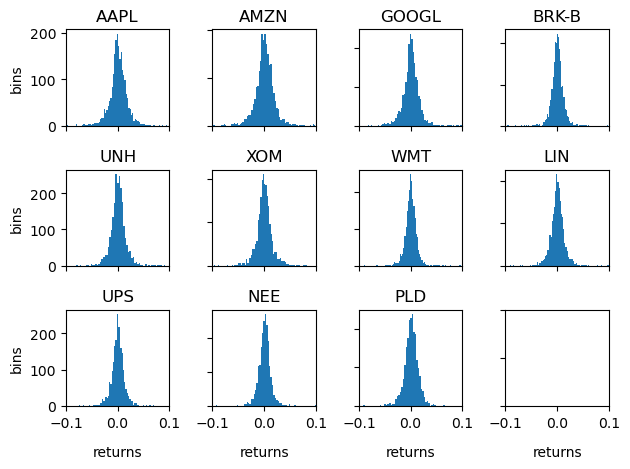

In [5]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

year_format = mdates.DateFormatter('%Y') 

def plot_ts_distribution(series_data, stocks_list, xlabel, ylabel, plot_type, x_limits=None, hide_xlabel=True):
    fig, axs = plt.subplots(3, 4)
    idx=0
    adf_statistics = []
    p_values = []
    for fig_row in range(3):
        for fig_col in range(4):
            if idx < len(stocks_list):
                stock_symbol = stocks_list[idx]
                stock_data = series_data[stock_symbol]
                if plot_type == "hist":
                    axs[fig_row, fig_col].hist(stock_data, bins=100)
                elif plot_type == "stationarity":
                    axs[fig_row, fig_col].plot(stock_data)
                    adf_statistic, p_value = adf_test(stock_data, stock_symbol)
                    adf_statistics.append(adf_statistic)
                    p_values.append(p_value)
                axs[fig_row, fig_col].set(title=stock_symbol)
                idx= idx+1

    for ax in axs.flat:
        ax.set(xlabel=xlabel, ylabel=ylabel)
        if x_limits:
            ax.set_xlim(x_limits)            
        if plot_type == "stationarity":
            ax.xaxis.set_major_formatter(year_format)
            ax.xaxis.set_major_locator(mdates.YearLocator(6))
        ax.set_xlabel(xlabel=xlabel, labelpad=11)
            
    for ax in axs.flat[:-4]:
        ax.set(xlabel="")
        
    # Hide x labels and tick labels for top plots and y ticks for right plots.
    if hide_xlabel:
        for ax in axs.flat:
            ax.label_outer()
            
    

    fig.tight_layout()

        
    if plot_type == "stationarity":
        print(pd.DataFrame({"stock": stocks_list, "ADF Statistic": adf_statistics, "p_values": p_values}))
        
plot_ts_distribution(stocks_return, stocks_list, "returns", "bins", "hist", [-0.1, 0.1])

    stock  ADF Statistic      p_values
0    AAPL     -15.233304  5.284590e-28
1    AMZN     -15.257280  4.915680e-28
2   GOOGL     -10.606085  5.997790e-19
3   BRK-B     -16.797991  1.226801e-29
4     UNH     -14.542401  5.120555e-27
5     XOM     -13.692350  1.336573e-25
6     WMT     -13.796603  8.726141e-26
7     LIN     -15.573294  1.974259e-28
8     UPS     -10.303939  3.316479e-18
9     NEE     -15.268486  4.752923e-28
10    PLD     -12.154478  1.543324e-22


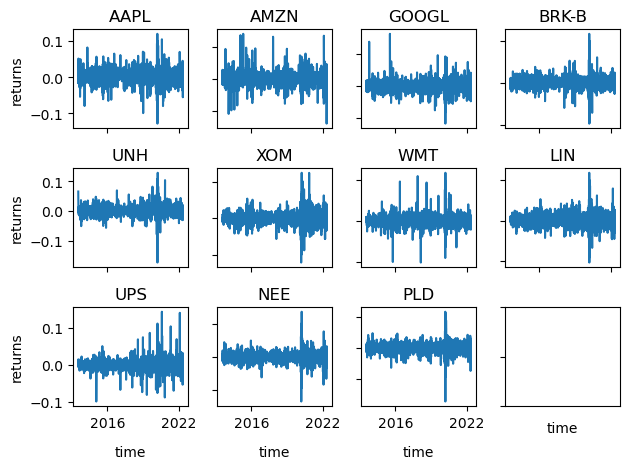

In [6]:
plot_ts_distribution(stocks_return, stocks_list, "time", "returns", "stationarity")

# Moving Average Convergence Divergence (MACD)

In [7]:
import pandas as pd
def get_macd(price, slow, fast, smooth):
    exp1 = price.ewm(span = fast, min_periods = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, min_periods = slow, adjust = False).mean()
    macd = pd.DataFrame(exp1 - exp2).rename(columns = {'Close':'macd'})
    signal = pd.DataFrame(macd.ewm(span = smooth, adjust = False).mean()).rename(columns = {'macd':'signal'})
    hist = pd.DataFrame(macd['macd'] - signal['signal']).rename(columns = {0:'hist'})
    frames =  [macd, signal, hist]
    df = pd.concat(frames, join = 'inner', axis = 1)
    df = df.dropna()
    return df


stocks_macd = {stock: get_macd(stocks_data[stock]["Close"], 26, 12, 9)['hist'] for stock in stocks_list}
stocks_macd["AAPL"].head()

Date
2013-08-21 00:00:00-04:00    0.000000
2013-08-22 00:00:00-04:00   -0.001416
2013-08-23 00:00:00-04:00   -0.011282
2013-08-26 00:00:00-04:00   -0.018153
2013-08-27 00:00:00-04:00   -0.055273
Name: hist, dtype: float64

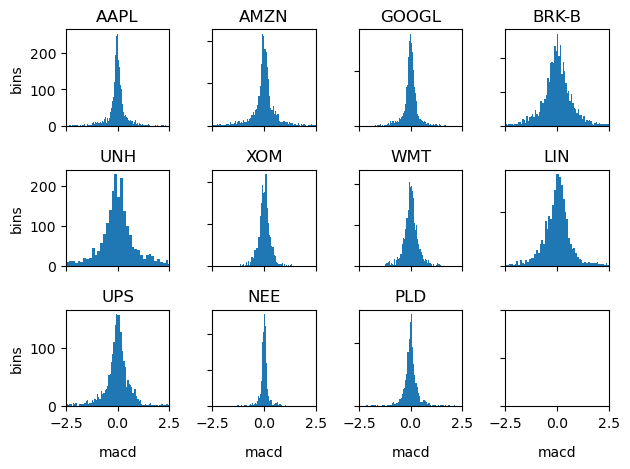

In [8]:
plot_ts_distribution(stocks_macd, stocks_list, "macd", "bins", "hist", [-2.5, 2.5])

    stock  ADF Statistic      p_values
0    AAPL     -10.573980  7.184358e-19
1    AMZN     -11.662361  1.919811e-21
2   GOOGL     -10.635360  5.088860e-19
3   BRK-B     -11.809597  8.925856e-22
4     UNH     -10.477409  1.238705e-18
5     XOM     -13.084484  1.841840e-24
6     WMT     -11.476255  5.122441e-21
7     LIN     -10.037926  1.523142e-17
8     UPS      -8.831165  1.768244e-14
9     NEE     -11.196456  2.300034e-20
10    PLD     -10.363420  2.363959e-18


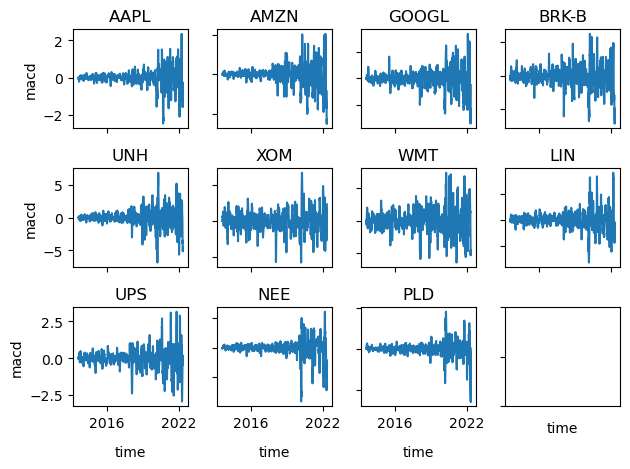

In [9]:
plot_ts_distribution(stocks_macd, stocks_list, "time", "macd", "stationarity")

# Price Rate of Change (ROC) Oscillator

In [10]:
# Rate of Change (ROC) - 12 days
def ROC(data,n):
    N = data.diff(n)
    D = data.shift(n)
    ROC = pd.Series(N/D,name='Rate of Change')
    return ROC

stocks_ROC = {stock: ROC(stocks_data[stock]["Close"], 12) for stock in stocks_list}
stocks_ROC["AAPL"].dropna().head()

Date
2013-08-02 00:00:00-04:00    0.074899
2013-08-05 00:00:00-04:00    0.087294
2013-08-06 00:00:00-04:00    0.094835
2013-08-07 00:00:00-04:00    0.090708
2013-08-08 00:00:00-04:00    0.107553
Name: Rate of Change, dtype: float64

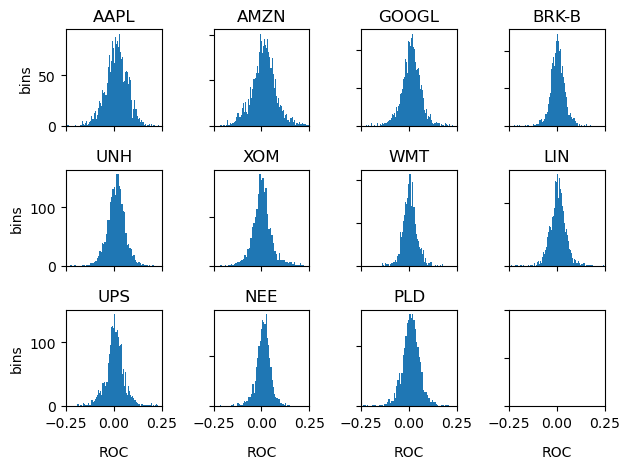

In [11]:
plot_ts_distribution(stocks_ROC, stocks_list, "ROC", "bins", "hist", [-0.25, 0.25])

    stock  ADF Statistic      p_values
0    AAPL      -7.206401  2.294208e-10
1    AMZN      -6.844050  1.761246e-09
2   GOOGL      -7.395030  7.818829e-11
3   BRK-B      -7.442884  5.941693e-11
4     UNH      -8.281361  4.510494e-13
5     XOM      -7.284260  1.472888e-10
6     WMT      -7.582694  2.656035e-11
7     LIN      -7.555477  3.107802e-11
8     UPS      -6.504314  1.141212e-08
9     NEE      -9.228383  1.704520e-15
10    PLD      -9.101372  3.598088e-15


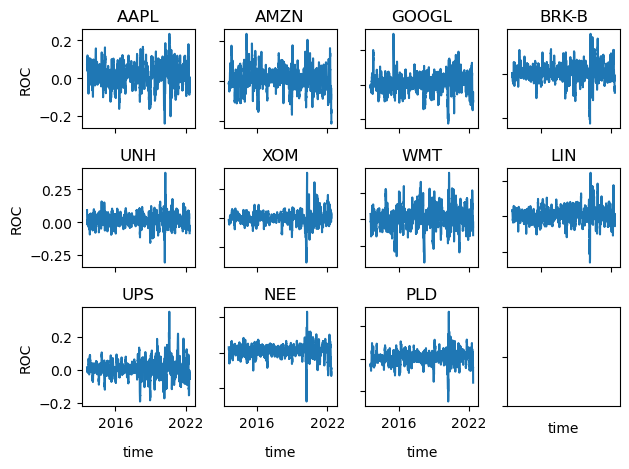

In [12]:
plot_ts_distribution(stocks_ROC, stocks_list, "time", "ROC", "stationarity")

# Volume Indicators

We begin by investigating whether the on-balance volume would make a good feature

## On Balance Volume

In [13]:
import numpy as np 
def calculate_obv(stock_data):
    obv = (np.sign(stock_data["Close"].diff()) * stock_data["Volume"]).fillna(0).cumsum()
    return pd.Series(obv)


stocks_obv = {stock: calculate_obv(stocks_data[stock]) for stock in stocks_list}
stocks_obv["AAPL"].head()

Date
2013-07-17 00:00:00-04:00            0.0
2013-07-18 00:00:00-04:00    218878800.0
2013-07-19 00:00:00-04:00    -49842800.0
2013-07-22 00:00:00-04:00    157953600.0
2013-07-23 00:00:00-04:00   -211442000.0
dtype: float64

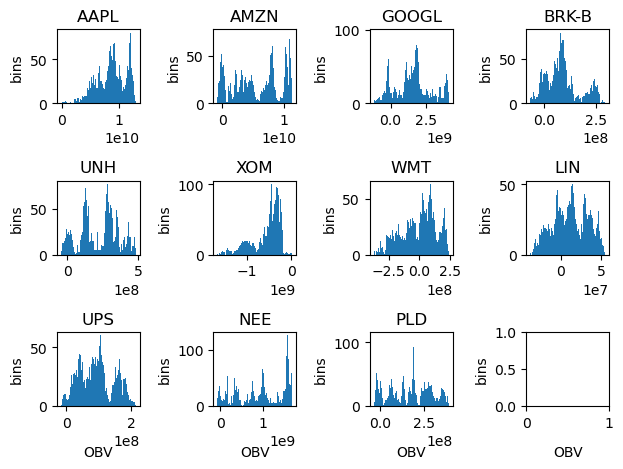

In [14]:
plot_ts_distribution(stocks_obv, stocks_list, "OBV", "bins", "hist", hide_xlabel=False)

    stock  ADF Statistic  p_values
0    AAPL      -2.910512  0.044139
1    AMZN      -0.812645  0.815379
2   GOOGL      -0.824391  0.811852
3   BRK-B      -1.174004  0.684677
4     UNH      -0.019612  0.956880
5     XOM      -2.055978  0.262580
6     WMT      -1.530720  0.518264
7     LIN      -2.288529  0.175694
8     UPS      -2.218398  0.199636
9     NEE      -1.547705  0.509794
10    PLD      -0.868024  0.798320


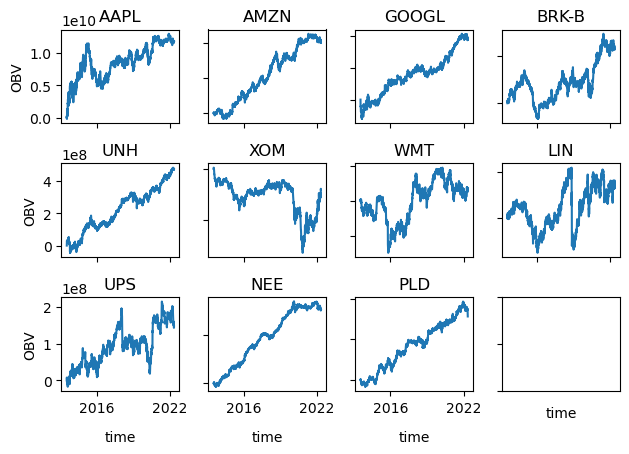

In [15]:
plot_ts_distribution(stocks_obv, stocks_list, "time", "OBV", "stationarity")

We can see the on-balance volume is non-stationariy. We can using differencing to stationarise it. Alternatively, we can use another volume indicator that is inherently more like to be stationariy. In this case, we use the Chaikin Oscillator which captures both the volume information and also takes into account the low and high prices for a given bar

## Chaikin Oscillator

In [16]:
def exponential_moving_average_series(ts, n):
    """
    :param df: pandas.DataFrame
    :param n:
    :return: pandas.DataFrame
    """
    EMA = pd.Series(ts.ewm(span = n, min_periods = n - 1).mean(), name = 'EMA_' + str(n))
    return EMA


def chaikin_oscillator(df):
    """Calculate Chaikin Oscillator for given data.
    :param df: pandas.DataFrame
    :return: pandas.DataFrame
    """
    ad = (2 * df['Close'] - df['High'] - df['Low']) * df['Volume'] / (df['High'] - df['Low'])
    ad = ad + ad.shift(1)

    ema3 = exponential_moving_average_series(ad,3);
    ema10 = exponential_moving_average_series(ad,10);

    chaikin = pd.Series((ema3-ema10), name='Chaikin')
    return chaikin

stocks_chaikin = {stock: chaikin_oscillator(stocks_data[stock])for stock in stocks_list}
stocks_chaikin["AAPL"].dropna().head()

Date
2013-07-30 00:00:00-04:00    1.474802e+08
2013-07-31 00:00:00-04:00    5.134541e+07
2013-08-01 00:00:00-04:00    6.158735e+07
2013-08-02 00:00:00-04:00    1.550214e+08
2013-08-05 00:00:00-04:00    1.887780e+08
Name: Chaikin, dtype: float64

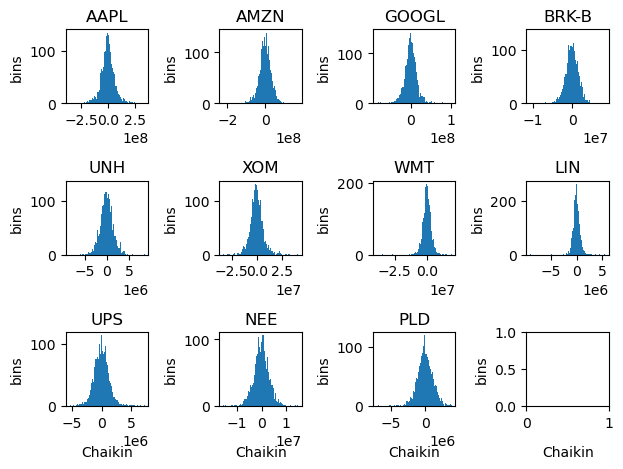

In [17]:
plot_ts_distribution(stocks_chaikin, stocks_list, "Chaikin", "bins", "hist", hide_xlabel=False)

    stock  ADF Statistic      p_values
0    AAPL     -12.537198  2.357414e-23
1    AMZN     -13.035790  2.294820e-24
2   GOOGL     -13.248576  8.870695e-25
3   BRK-B     -13.551472  2.404788e-25
4     UNH     -12.533286  2.402204e-23
5     XOM     -12.211808  1.159208e-22
6     WMT     -12.383916  4.958234e-23
7     LIN     -13.769293  9.750583e-26
8     UPS     -13.990585  4.023330e-26
9     NEE     -12.904122  4.187772e-24
10    PLD     -13.343208  5.863993e-25


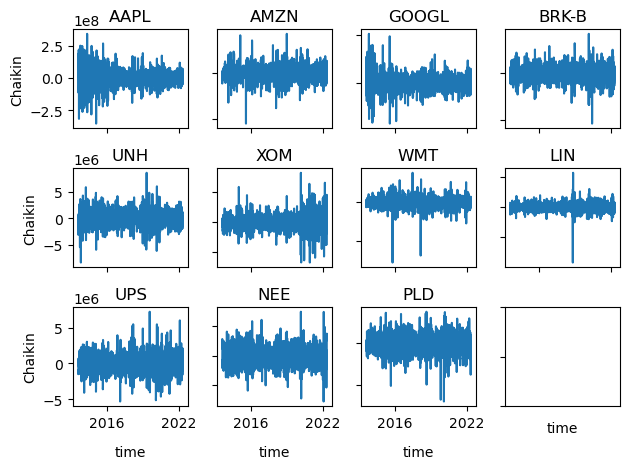

In [18]:
plot_ts_distribution(stocks_chaikin, stocks_list, "time", "Chaikin", "stationarity")

# Visualise features after Transformation

We can now visualise all four of the features (Returns, MACD, ROC, Chaikin) we plan to use after standardising. We use the standard scaler transformation for simpilicity. We could have use other transformations as well such as quantile transforms or power transforms.

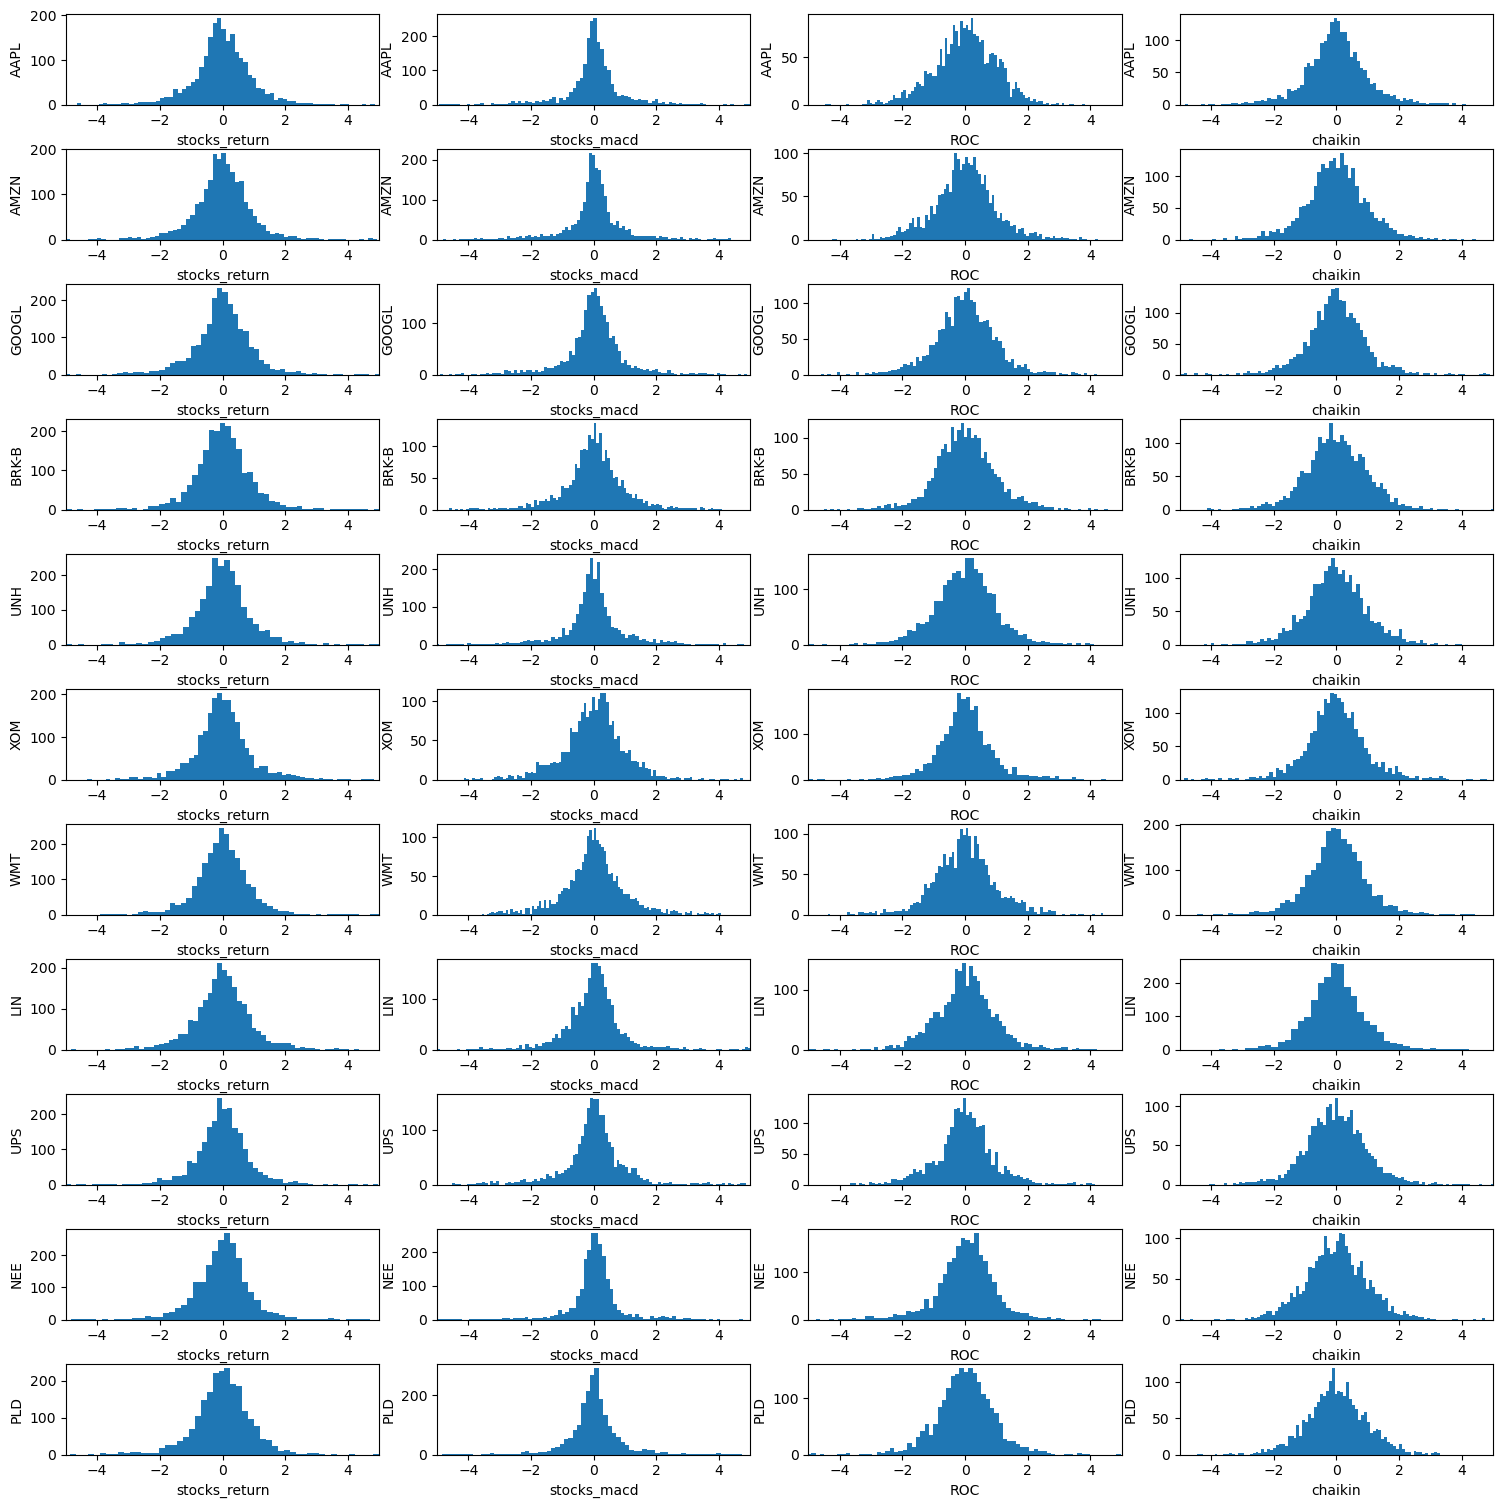

In [19]:
from sklearn.preprocessing import StandardScaler

def join_features_for_visualisation(stocks_features_data, stocks_list):
    transformers = {}
    stock_combined_features = {}
    for stock in stocks_list:
        feature_list = []
        for feature in stocks_features_data:
            feature_list.append(feature[stock])
        combined_features = pd.concat(feature_list, axis=1).reset_index()
        combined_features = combined_features.dropna()
        combined_features = combined_features.drop(columns=['Date'])
        scaler = StandardScaler()
        fitted_features = scaler.fit_transform(combined_features)
        stock_combined_features[stock] = fitted_features
        transformers[stock] = scaler
    return stock_combined_features, transformers
features_list = [stocks_return, stocks_macd]
joined_features = join_features_for_visualisation([stocks_return, stocks_macd, stocks_ROC, stocks_chaikin], stocks_list)

def plot_multiple_ts_distribution(multiple_ts_series_data, stocks_list, features_names):
    num_rows = len(stocks_list)
    num_ts = len(features_names)
    fig, axs = plt.subplots(num_rows, num_ts, figsize=(15, 15))
    fig.tight_layout() 
    for fig_row, stock in enumerate(stocks_list):
        for fig_col, feature_name in enumerate(features_names):
            stock_data = multiple_ts_series_data[stock]
            axs[fig_row, fig_col].hist(stock_data[:, fig_col], bins=100)
            axs[fig_row, fig_col].set(ylabel=stock)
            axs[fig_row, fig_col].set(xlabel=feature_name)
            axs[fig_row, fig_col].set_xlim([-5, 5])
    
plot_multiple_ts_distribution(joined_features[0], stocks_list, ["stocks_return", "stocks_macd", "ROC", "chaikin"])

# Relationship between features

High multicollinearity between features might not affect the prediction power of the model but it is interesting to understand the interpretability of the impact of the features on the outcome. Even though we aren't necessarily using a linear model, the variance inflation factor (VIF) is one way to understand the relationship among features.

In [20]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
stock_comb_features = joined_features[0]

feature_vif_dict = {"Returns_VIF":[], "MACD_VIF":[], "ROC_VIF":[], "Chaikin_VIF":[]}
returns_vif = []
MACD_vif = []
ROC_vif = []
Chaikin_vif = []
for stock in stocks_list:
    features_data = stock_comb_features[stock]
    for feature_idx, (name, vif_list) in enumerate(feature_vif_dict.items()): 
        vif_value = variance_inflation_factor(features_data, feature_idx)
        vif_list.append(vif_value)
vif_output = {"stock": stocks_list, **feature_vif_dict}
pd.DataFrame(vif_output)

,stock,Returns_VIF,MACD_VIF,ROC_VIF,Chaikin_VIF
0,AAPL,1.198009,1.868832,1.982258,1.105518
1,AMZN,1.234958,1.953780,2.084285,1.133270
2,GOOGL,1.198137,2.324739,2.448472,1.107905
3,BRK-B,1.231356,3.200031,3.353947,1.138205
4,UNH,1.233354,2.576539,2.691423,1.155419
5,XOM,1.237063,2.749886,2.879733,1.149288
6,WMT,1.277080,2.636990,2.813233,1.159464
7,LIN,1.160339,2.717473,2.862403,1.065236
8,UPS,1.282661,2.856223,2.999562,1.187435
9,NEE,1.243260,2.916612,3.032224,1.164408


As we can see the VIF between the features is not very high and consequently the multicollinearity between them isn't very high

# Prepare Features and Target labels for Model

We combine the features in a single array and also prepare its corresponding target vector. The target vector is obtained from the labeled data for profit taking / stop loss

In [21]:
from sklearn.preprocessing import StandardScaler

def prepare_features_and_labels(stocks_features_data, labels, stocks_list):
    transformers = {}
    stock_combined_features = {}
    stock_filtered_labels = {}
    for stock in stocks_list:
        feature_list = []
        for feature in stocks_features_data:
            feature_list.append(feature[stock])
        combined_features = pd.concat(feature_list, axis=1).reset_index()
        combined_features = combined_features.dropna()
      
        start_date = combined_features["Date"].iloc[0]
        end_date = combined_features["Date"].iloc[-1]
        combined_features = combined_features.set_index("Date")
        labels_data = labels[stock]["label"]
        filtered_labels = labels_data[(labels_data.index >= start_date) & (labels_data.index <= end_date)]
        stock_combined_features[stock] = combined_features
        stock_filtered_labels[stock] = filtered_labels
    return stock_combined_features, stock_filtered_labels
features_list = [stocks_return, stocks_macd, stocks_ROC, stocks_chaikin]
stocks_train_data, stocks_label_data = prepare_features_and_labels(features_list, stocks_data, stocks_list)
print(stocks_train_data["AAPL"].head())
print(stocks_label_data["AAPL"].head())

                            returns      hist  Rate of Change       Chaikin
Date                                                                       
2013-08-21 00:00:00-04:00  0.002575  0.000000        0.077169 -3.186950e+08
2013-08-22 00:00:00-04:00  0.001194 -0.001416        0.088191 -1.995249e+08
2013-08-23 00:00:00-04:00 -0.003857 -0.011282        0.084623 -7.924406e+07
2013-08-26 00:00:00-04:00  0.003892 -0.018153        0.091018 -9.676100e+07
2013-08-27 00:00:00-04:00 -0.028590 -0.055273        0.075124 -1.801074e+08
Date
2013-08-21 00:00:00-04:00    0
2013-08-22 00:00:00-04:00   -1
2013-08-23 00:00:00-04:00   -1
2013-08-26 00:00:00-04:00   -1
2013-08-27 00:00:00-04:00    0
Name: label, dtype: int64


# Model Cross Validation with Purged and Embargoed Data

For hyperparameter tuning our model, we split the traing set into training + validation sets. For time series data, we try and ensure there is no data leakage from the future into the past. Since our labels use 5 days future data, we ensure the features used for validation does not include this 5 days. Also, the features use a maximum of 26 days of past data for its moving average calculations. Hence, we ensure that there is no overlap in the data used for feature construction for validation and training by taking into account this 26 day gap. Overall we wensure that there is at least a 31 day gap between training and validation. The validation set size is chosen depending on the number of walkforwards and training set size. We use a fixed training size of 7 years. Note we also ensure there is a similar gap between the final validation set and the complete out of sample, one year backtest data.

In [22]:
def ts_splits_validation(num_data_points, training_size, num_walkforwards, jump, pre_gap, post_gap):
    cv_splits = []
    test_size = int((num_data_points - (training_size)) - (jump)*num_walkforwards) 
    for n in range(num_walkforwards):
        train_indices = np.array(range(n*jump, training_size + n*jump))
        test_indices = np.array(range(training_size + pre_gap + post_gap + n*jump -1, training_size + pre_gap + post_gap + test_size + n*jump - 1))
        cv_splits.append((train_indices, test_indices))
    return cv_splits  
cv_splits = ts_splits_validation(train_size - (26+5+1), 7*252, 9, 30, 26, 5)
print("num_splits:", len(cv_splits))

num_splits: 9


## Model for classifying profit taking / stop loss/ trade expiry

We use an XGBoost model for classification. Alternatively we could have used a simpler model such as a logistic regression or SVM classifier or a more complicated model such as a neural net.

### Individual Stock Predictions

We begin by training and predicting labels for a single stock before extending this to multiple stocks and mutiple test sets.

We choose the evaluation metric to be the negative log likelihood as that also takes the probability of classification into account. We shift the profit taking / stop loss/ trade expiry classes from 1, -1, 0 to 2, 0, 1. This is because for multiclassification sklearn scikitlearn prefers positive integers.

In [23]:
import xgboost as xgb
from scipy import stats
from scipy.stats import randint
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV

clf_xgb = xgb.XGBClassifier(objective = 'multi:softprob', random_state = 42)
param_dist = {
    'classifier__n_estimators': stats.randint(600, 1000),
    'classifier__learning_rate': stats.uniform(0.001, 0.005),
    'classifier__subsample': stats.uniform(0.5, 0.4),
    'classifier__max_depth': [3, 4, 5, 6],
    'classifier__colsample_bytree': stats.uniform(0.3, 0.6),
    'classifier__min_child_weight': [1, 2, 3, 4, 5],
}
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', clf_xgb)
])

clf = RandomizedSearchCV(
    pipeline, 
    param_distributions = param_dist,
    cv = cv_splits,  
    n_iter = 10, # you want 5 here not 25 if I understand you correctly 
    scoring = 'neg_log_loss', 
    error_score = 0, 
    verbose = 0, 
    n_jobs = -1
)
clf.fit(stocks_train_data["AAPL"], stocks_label_data["AAPL"] + 1)

print("best_params:", clf.best_params_)
print("best_score:", clf.best_score_)

best_params: {'classifier__colsample_bytree': 0.4958897168257008, 'classifier__learning_rate': 0.0018376267535828643, 'classifier__max_depth': 4, 'classifier__min_child_weight': 5, 'classifier__n_estimators': 739, 'classifier__subsample': 0.5928426488417295}
best_score: -1.0811911736155997


In [24]:
final_params = clf.best_params_
final_params = {key.replace("classifier__", ""): value for key, value in final_params.items()}
final_params

{'colsample_bytree': 0.4958897168257008,
 'learning_rate': 0.0018376267535828643,
 'max_depth': 4,
 'min_child_weight': 5,
 'n_estimators': 739,
 'subsample': 0.5928426488417295}

In [25]:
clf_xgb_pipe = xgb.XGBClassifier(objective = 'multi:softprob', **final_params)
pipeline_final = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('classifier', clf_xgb_pipe)
])
pipeline_final.fit(stocks_train_data["AAPL"], stocks_label_data["AAPL"] + 1)
print("predicted label", pipeline_final.predict(stocks_train_data["AAPL"].iloc[[2]]))
print("predicted probabilities of all classes", pipeline_final.predict_proba(stocks_train_data["AAPL"].iloc[[2]]))

predicted label [2]
predicted probabilities of all classes [[0.34474343 0.3080258  0.3472307 ]]


### Model Predictions for multiple stocks

We extend what we've done above to multiple stocks by finding the best parameters for an XGBoost model per stock and then using those best fit prameters to make predictions on unseen data. Note that ideally we would refit the model with new data every data. However, this is computationally intensive and for simplicity we use the best fit model at the begining of our test period. Later we will use Monte Carlo simulations to generate the closing prices for the different stocks to backtest multiple price paths. For the Chaikin oscillator, we require the high and low price and the volume as well. We use the true out of sample data for these values. We calculate the low and high prices by using the difference between the simulated and the true closing prices. For the volume, we just take the true volume.

In [26]:
def find_best_model_params_per_stock(stock, training_data, label_data):
    clf_xgb = xgb.XGBClassifier(objective = 'multi:softprob', random_state = 42)
    param_dist = {      
        'classifier__n_estimators': stats.randint(600, 1000),
        'classifier__learning_rate': stats.uniform(0.001, 0.005),
        'classifier__subsample': stats.uniform(0.5, 0.4),
        'classifier__max_depth': [3, 4, 5, 6],
        'classifier__colsample_bytree': stats.uniform(0.3, 0.6),
        'classifier__min_child_weight': [1, 2, 3, 4, 5],
    }
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', clf_xgb)
    ])

    clf = RandomizedSearchCV(
        pipeline, 
        param_distributions = param_dist,
        cv = cv_splits,  
        n_iter = 10, # you want 5 here not 25 if I understand you correctly 
        scoring = 'neg_log_loss', 
        error_score = 0, 
        verbose = 0, 
        n_jobs = -1
    )
    clf.fit(training_data[stock], label_data[stock] + 1)
    final_params = clf.best_params_
    print("best_params:", clf.best_params_)
    print("best_score:", clf.best_score_)
    final_params = {key.replace("classifier__", ""): value for key, value in final_params.items()}
    return final_params


def fit_model_per_stock(stock, training_data, label_data, best_params, training_size):
    clf_xgb_pipe = xgb.XGBClassifier(objective = 'multi:softprob', **best_params[stock])
    model_pipeline = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('classifier', clf_xgb_pipe)
    ])
    model_pipeline.fit(training_data[stock][-training_size:], label_data[stock][-training_size:] + 1)
    return model_pipeline


def calculate_chaikin_oscillator(close, high, low, volume):
    """Calculate Chaikin Oscillator for given data.
    :param df: pandas.DataFrame
    :return: pandas.DataFrame
    """
    ad = (2 * close - high - low) * volume / (high - low)
    ad = ad + ad.shift(1)

    ema3 = exponential_moving_average_series(ad,3);
    ema10 = exponential_moving_average_series(ad,10);

    Chaikin = pd.Series((ema3-ema10), name='Chaikin')
    return Chaikin


def calulate_test_macd(price, slow, fast, smooth):
    exp1 = price.ewm(span = fast, min_periods = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, min_periods = slow, adjust = False).mean()
    macd = exp1 - exp2
    signal = macd.ewm(span = smooth, adjust = False).mean()
    hist = macd - signal
    hist = hist.dropna()
    return hist


def predicted_labels_per_stock(stock_list, full_test_data, fitted_model_pipeline, true_test_data):
    final_data = full_test_data.iloc[-253:].copy()
    for stock in stock_list:
        true_data = true_test_data[stock].iloc[-(len(full_test_data)):].reset_index()
        returns_feature = get_returns(full_test_data[stock])
        macd_feature = calulate_test_macd(full_test_data[stock], 26, 12, 9).rename("hist")
        ROC_feature = ROC(full_test_data[stock], 12)
        # High, Low, volume use true test data     
        diff = full_test_data[stock] - true_data["Close"]
        high = true_data["High"] + diff
        low = true_data["Low"] + diff
        chaikin_feature = calculate_chaikin_oscillator(full_test_data[stock], high, low, true_data["Volume"])
        features_list = [returns_feature, macd_feature, ROC_feature, chaikin_feature]
        features = pd.concat(features_list, axis=1).dropna()
        final_data[f"{stock}_label"] = fitted_model_pipeline[stock].predict(features)
        final_data[f"{stock}_probs"] = fitted_model_pipeline[stock].predict_proba(features).max(axis=1)
    return final_data.reset_index()

In [27]:
stocks_model_params = {stock: find_best_model_params_per_stock(stock, stocks_train_data, stocks_label_data) for stock in stocks_list}
stocks_model_params

best_params: {'classifier__colsample_bytree': 0.3842101593803784, 'classifier__learning_rate': 0.002171854224641402, 'classifier__max_depth': 3, 'classifier__min_child_weight': 3, 'classifier__n_estimators': 726, 'classifier__subsample': 0.61906706202309}
best_score: -1.077463968171433
best_params: {'classifier__colsample_bytree': 0.3556814868050385, 'classifier__learning_rate': 0.0016425217773574504, 'classifier__max_depth': 4, 'classifier__min_child_weight': 3, 'classifier__n_estimators': 793, 'classifier__subsample': 0.5725744791320041}
best_score: -1.0974639599702247
best_params: {'classifier__colsample_bytree': 0.6913720797421847, 'classifier__learning_rate': 0.0025870499405799955, 'classifier__max_depth': 3, 'classifier__min_child_weight': 3, 'classifier__n_estimators': 906, 'classifier__subsample': 0.5343945366277514}
best_score: -1.0610780973035152
best_params: {'classifier__colsample_bytree': 0.6816970633280394, 'classifier__learning_rate': 0.001887270524704283, 'classifier__m

{'AAPL': {'colsample_bytree': 0.3842101593803784,
  'learning_rate': 0.002171854224641402,
  'max_depth': 3,
  'min_child_weight': 3,
  'n_estimators': 726,
  'subsample': 0.61906706202309},
 'AMZN': {'colsample_bytree': 0.3556814868050385,
  'learning_rate': 0.0016425217773574504,
  'max_depth': 4,
  'min_child_weight': 3,
  'n_estimators': 793,
  'subsample': 0.5725744791320041},
 'GOOGL': {'colsample_bytree': 0.6913720797421847,
  'learning_rate': 0.0025870499405799955,
  'max_depth': 3,
  'min_child_weight': 3,
  'n_estimators': 906,
  'subsample': 0.5343945366277514},
 'BRK-B': {'colsample_bytree': 0.6816970633280394,
  'learning_rate': 0.001887270524704283,
  'max_depth': 3,
  'min_child_weight': 2,
  'n_estimators': 669,
  'subsample': 0.7732397521418419},
 'UNH': {'colsample_bytree': 0.5302859132333781,
  'learning_rate': 0.0010448089035848148,
  'max_depth': 5,
  'min_child_weight': 4,
  'n_estimators': 962,
  'subsample': 0.7816611292007623},
 'XOM': {'colsample_bytree': 0.67

In [28]:
stocks_fitted_models = {stock: fit_model_per_stock(stock, stocks_train_data, stocks_label_data, stocks_model_params, 7*252) for stock in stocks_list}
stocks_fitted_models

{'AAPL': Pipeline(steps=[('scaler', StandardScaler()),
                 ('classifier',
                  XGBClassifier(base_score=None, booster=None, callbacks=None,
                                colsample_bylevel=None, colsample_bynode=None,
                                colsample_bytree=0.3842101593803784,
                                early_stopping_rounds=None,
                                enable_categorical=False, eval_metric=None,
                                feature_types=None, gamma=None, gpu_id=None,
                                grow_policy=None, importance_type=None,
                                interaction_constraints=None,
                                learning_rate=0.002171854224641402, max_bin=None,
                                max_cat_threshold=None, max_cat_to_onehot=None,
                                max_delta_step=None, max_depth=3,
                                max_leaves=None, min_child_weight=3, missing=nan,
                             

In [29]:
def combine_stocks_data(stocks_dict, column):
    data_list = []
    for stock, data in stocks_dict.items():
        series_data = data[column].dropna()
        series_data.name = stock
        data_list.append(series_data)
    combined_data = pd.concat(data_list, axis=1).reset_index()
    combined_data = combined_data.set_index("Date")
    return combined_data

test_stock_prices = combine_stocks_data(stocks_test_data, "Close")
test_stock_prices

,AAPL,AMZN,GOOGL,BRK-B,UNH,XOM,WMT,LIN,UPS,NEE,PLD
Date,,,,,,,,,,,
2022-05-16 00:00:00-04:00,144.676102,110.810501,114.445000,309.290009,480.770386,87.910309,145.858932,303.723236,173.568604,68.155296,120.990334
2022-05-17 00:00:00-04:00,148.354141,115.368500,116.473000,314.600006,484.023193,89.031548,129.266388,312.880859,176.822342,70.002045,121.618233
2022-05-18 00:00:00-04:00,139.984131,107.112503,111.899498,306.640015,463.238495,87.620338,120.487877,304.341614,166.288681,69.010628,115.464874
2022-05-19 00:00:00-04:00,136.534729,107.319000,110.384003,304.149994,470.284607,88.093971,117.181175,304.959991,161.615662,68.485764,115.648415
2022-05-20 00:00:00-04:00,136.773285,107.591003,108.907997,304.049988,477.340607,88.789902,117.309120,309.357178,165.139755,69.224457,115.648415
...,...,...,...,...,...,...,...,...,...,...,...
2023-07-10 00:00:00-04:00,188.610001,127.129997,116.449997,341.130005,463.049988,104.690002,154.880005,367.549988,181.330002,71.709999,121.809998
2023-07-11 00:00:00-04:00,188.080002,128.779999,117.139999,343.369995,462.890015,105.970001,154.649994,366.839996,185.240005,72.190002,123.220001
2023-07-12 00:00:00-04:00,189.770004,130.800003,118.930000,345.350006,451.700012,106.489998,155.039993,374.600006,186.490005,73.470001,125.239998


In [30]:
check_prices = test_stock_prices.reset_index().iloc[-278:]
check_appl = predicted_labels_per_stock(["AAPL"], check_prices, stocks_fitted_models, stocks_test_data)
check_appl["AAPL_label"].value_counts()

2    219
0     21
1     13
Name: AAPL_label, dtype: int64

In [31]:
predicted_stocks_labels = predicted_labels_per_stock(stocks_list, check_prices, stocks_fitted_models, stocks_test_data)
predicted_stocks_labels

,index,Date,AAPL,AMZN,GOOGL,BRK-B,UNH,XOM,WMT,LIN,...,WMT_label,WMT_probs,LIN_label,LIN_probs,UPS_label,UPS_probs,NEE_label,NEE_probs,PLD_label,PLD_probs
0,39,2022-07-13 00:00:00-04:00,144.626404,110.400002,111.353500,277.470001,494.339355,82.004517,123.381248,270.645233,...,1,0.434414,2,0.401565,2,0.360687,2,0.441403,2,0.385382
1,40,2022-07-14 00:00:00-04:00,147.588715,110.629997,110.367500,274.410004,495.513000,80.361336,125.792374,265.010284,...,1,0.378360,2,0.439517,2,0.376880,2,0.421513,2,0.419469
2,41,2022-07-15 00:00:00-04:00,149.278625,113.550003,111.777496,278.480011,522.456909,81.714546,127.022552,272.861816,...,1,0.460330,2,0.364072,2,0.389190,2,0.372493,2,0.381437
3,42,2022-07-18 00:00:00-04:00,146.197021,113.760002,109.029999,276.260010,512.219727,83.222412,126.727325,273.009583,...,1,0.444237,0,0.347726,2,0.354053,1,0.348910,2,0.396145
4,43,2022-07-19 00:00:00-04:00,150.103714,118.209999,113.809998,283.549988,526.105896,85.319885,127.504776,281.501404,...,1,0.431934,2,0.419213,1,0.365641,2,0.349871,2,0.362449
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,287,2023-07-10 00:00:00-04:00,188.610001,127.129997,116.449997,341.130005,463.049988,104.690002,154.880005,367.549988,...,2,0.375847,2,0.357645,1,0.414251,1,0.344234,2,0.371584
249,288,2023-07-11 00:00:00-04:00,188.080002,128.779999,117.139999,343.369995,462.890015,105.970001,154.649994,366.839996,...,2,0.350776,2,0.353116,1,0.418641,1,0.372249,2,0.358435
250,289,2023-07-12 00:00:00-04:00,189.770004,130.800003,118.930000,345.350006,451.700012,106.489998,155.039993,374.600006,...,2,0.371368,1,0.351521,1,0.410468,2,0.385840,2,0.361150
251,290,2023-07-13 00:00:00-04:00,190.539993,134.300003,124.540001,343.540009,447.750000,104.540001,154.130005,377.140015,...,2,0.355843,2,0.337924,1,0.452345,2,0.407051,2,0.394930


# Toy Investment Strategy

We now implement a toy investment strategy using our XGBoost model. We rebalance our portfolio every 22 days and sell each stock on any day that the model predicts a stop loss or a profit taking opportunity above a particular probability threshold. We choose the probability threshold to be about 40%, slightly above the minimum 1/3 probability we would expect from having 3 possible classes. We do not sell more than 5% of the optimal value of a stock in the portfolio on any given day. If we hit 0, we stop selling the stock until the rebalancing date. 

In [32]:
total_stock_prices = combine_stocks_data(stocks_train_test_data, "Close")
total_stock_prices

,AAPL,AMZN,GOOGL,BRK-B,UNH,XOM,WMT,LIN,UPS,NEE,PLD
Date,,,,,,,,,,,
2013-07-15 00:00:00-04:00,13.253650,15.328500,23.140390,117.209999,58.019176,60.870445,61.973278,95.493248,63.311893,16.507778,29.329676
2013-07-16 00:00:00-04:00,13.339231,15.343500,23.013264,117.199997,57.410007,60.903091,62.246815,95.132492,63.682251,16.415033,29.352074
2013-07-17 00:00:00-04:00,13.342637,15.434500,22.986736,117.629997,56.826542,61.007523,62.110039,95.485077,64.178482,16.386055,29.852474
2013-07-18 00:00:00-04:00,13.387599,15.205500,22.789789,118.559998,60.533188,61.608078,62.222679,95.681847,65.067261,16.505848,30.203510
2013-07-19 00:00:00-04:00,13.176438,15.261500,22.437437,118.900002,61.305405,62.123722,62.818043,96.042595,65.237656,16.415033,30.143774
...,...,...,...,...,...,...,...,...,...,...,...
2023-07-10 00:00:00-04:00,188.610001,127.129997,116.449997,341.130005,463.049988,104.690002,154.880005,367.549988,181.330002,71.709999,121.809998
2023-07-11 00:00:00-04:00,188.080002,128.779999,117.139999,343.369995,462.890015,105.970001,154.649994,366.839996,185.240005,72.190002,123.220001
2023-07-12 00:00:00-04:00,189.770004,130.800003,118.930000,345.350006,451.700012,106.489998,155.039993,374.600006,186.490005,73.470001,125.239998


In [33]:
from pypfopt.hierarchical_portfolio import HRPOpt
from math import sqrt

INITAL_PORTFOLIO_VALUE = 10000

def convert_weights_to_shares(weight, portfolio_value, share_price):
    num_of_shares = (weight*portfolio_value)/share_price
    return num_of_shares


def find_optimum_portfolio(total_prices_data, test_days):
    left_over_prices = total_prices_data.iloc[:-test_days]
    left_over_price_returns = left_over_prices/ left_over_prices.shift(1) - 1
    left_over_price_returns = left_over_price_returns.dropna()
    HRP_portfolio = HRPOpt(left_over_price_returns)
    optimised_portfolio = HRP_portfolio.optimize()
    return optimised_portfolio

def sell_and_rebalance(test_prices, total_stock_prices, test_days, print_results=False):
    PROB_THRESHOLD = 0.40
    STOCK_CAP = 0.05
    portfolio_value_data = test_prices.copy()
    optimum_portfolio = find_optimum_portfolio(total_stock_prices, 252)
    start_idx = len(portfolio_value_data) - 252 -1
    num_of_shares = {}
    for stock, weight in optimum_portfolio.items():
        shares = convert_weights_to_shares(weight, INITAL_PORTFOLIO_VALUE, portfolio_value_data[stock].iloc[start_idx])
        num_of_shares[stock] = shares
        portfolio_value_data.loc[portfolio_value_data.index[start_idx], f"{stock}_value"] = portfolio_value_data[stock].iloc[start_idx]*shares

    portfolio_value_data["cash"] = 0
    stock_values_list = [f"{stock}_value" for stock in stocks_list]
    stock_values_list.append("cash")
    optimum_portfolio_value = portfolio_value_data.loc[portfolio_value_data.index[start_idx], stock_values_list].sum()
    next_portfolio_value = INITAL_PORTFOLIO_VALUE
    prev_cash_value = 0
    idx_row = 0
    for idx, row in portfolio_value_data.iloc[(start_idx):].iterrows():
        for stock in stocks_list:
            portfolio_value_data.at[idx,f"{stock}_value"] = row[stock]*num_of_shares[stock]
        portfolio_value_data.at[idx, "cash"] = prev_cash_value
        next_portfolio_value = portfolio_value_data.loc[idx, stock_values_list].sum()
        portfolio_value_data.at[idx, "portfolio_value"] = next_portfolio_value
        current_portfolio_value = next_portfolio_value
        if idx_row % 22 == 0:
            optimum_portfolio = find_optimum_portfolio(total_stock_prices, 252 - idx_row)
            for stock, weight in optimum_portfolio.items():
                shares = convert_weights_to_shares(weight, next_portfolio_value, row[stock])
                num_of_shares[stock] = shares
                portfolio_value_data.at[idx,f"{stock}_value"] = row[stock]*shares
            portfolio_value_data.at[idx,"cash"] = 0
            prev_cash_value = 0
            optimum_portfolio_value = portfolio_value_data.loc[idx, stock_values_list].sum()
        else:
            num = 0
            total_value = prev_cash_value
            for stock in stocks_list:
                if (row[f"{stock}_label"]!=1) and (row[f"{stock}_probs"]>=PROB_THRESHOLD):
                    sell_value =  STOCK_CAP * row[f"{stock}_probs"]*optimum_portfolio[stock]*optimum_portfolio_value
                    left_over_stock_value = portfolio_value_data.at[idx,f"{stock}_value"]  - sell_value
                    final_value = max(0, left_over_stock_value)
                    actual_sell_value = min(sell_value, portfolio_value_data.at[idx,f"{stock}_value"])
                    total_value += actual_sell_value
                    portfolio_value_data.at[idx,f"{stock}_value"] = final_value
                    weight = final_value / next_portfolio_value
                    shares = convert_weights_to_shares(weight, next_portfolio_value, row[stock])
                    num_of_shares[stock] = shares
            portfolio_value_data.at[idx, "cash"] = total_value
            prev_cash_value = total_value
        idx_row += 1  
    
    portfolio_value_returns = get_returns(portfolio_value_data["portfolio_value"]).dropna()
    annualised_expected_returns = (1+portfolio_value_returns).prod()**(252/len(portfolio_value_returns)) - 1 
    annualised_expected_std = portfolio_value_returns.std()*sqrt(252)
    if print_results:
        print("num of test days", len(portfolio_value_returns))
        print("expected returns", annualised_expected_returns)
        print("std dev of returns", annualised_expected_std)
        print("skew of returns", portfolio_value_returns.skew())
        print("kurtosis of returns", portfolio_value_returns.kurtosis())
    SR = (annualised_expected_returns - 0.02) / annualised_expected_std 
    return SR
Sharpe_ratio = sell_and_rebalance(predicted_stocks_labels, total_stock_prices, 252, print_results=True)
print("Sharpe Ratio", Sharpe_ratio)

num of test days 252
expected returns 0.17451054931987775
std dev of returns 0.1736280217203855
skew of returns 0.3006752549807136
kurtosis of returns 1.0898343056057227
Sharpe Ratio 0.8898940838518857


# Buy and Hold Strategy

We compare our toy model to a simple buy and hold strategy. We construct our optimal portfolio at the start of the backtesting period and see how the portfolio performs till the most recent date

In [34]:
from pypfopt.hierarchical_portfolio import HRPOpt
from math import sqrt

INITAL_PORTFOLIO_VALUE = 10000

def buy_and_hold(test_prices, last_non_test_day_prices, optimised_portfolio, test_days, print_results=False):
    portfolio_value_data = test_prices.iloc[-test_days:].copy()
    portfolio_value_data.loc[-1] = test_prices.iloc[-(test_days+1)]
    portfolio_value_data.index = portfolio_value_data.index + 1  # shifting index
    portfolio_value_data.sort_index(inplace=True)
    num_of_shares = {}
    for stock, weight in optimised_portfolio.items():
        shares = convert_weights_to_shares(weight, INITAL_PORTFOLIO_VALUE, last_non_test_day_prices[stock])
        num_of_shares[stock] = shares
        portfolio_value_data[stock] = portfolio_value_data[stock]*shares
    portfolio_value_summed = portfolio_value_data[list(optimised_portfolio.keys())].sum(axis=1)
    portfolio_value_returns = get_returns(portfolio_value_summed).dropna()
    annualised_expected_returns = (1+portfolio_value_returns).prod()**(252/len(portfolio_value_returns)) - 1 
    annualised_expected_std = portfolio_value_returns.std()*sqrt(252)
    if print_results:
        print(len(portfolio_value_returns))
        print("expected returns", annualised_expected_returns)
        print("std dev of returns", annualised_expected_std)
        print("skew of returns", portfolio_value_returns.skew())
        print("kurtosis of returns", portfolio_value_returns.kurtosis())
    SR = (annualised_expected_returns - 0.02) / annualised_expected_std 
    return SR
optimum_portfolio = find_optimum_portfolio(total_stock_prices, 252)
last_non_test_day_prices = total_stock_prices.iloc[-253]
test_price_trial = total_stock_prices.iloc[-253:].reset_index().drop(columns=["Date"])
buy_hold_SR = buy_and_hold(test_price_trial, last_non_test_day_prices, optimum_portfolio, 252, print_results=True)
print("Sharpe Ratio", buy_hold_SR)

252
expected returns 0.17412090155748272
std dev of returns 0.18212082544151711
skew of returns 0.24955434851511224
kurtosis of returns 1.2515253546418217
Sharpe Ratio 0.8462563311134027


# Monte Carlo Price Simulation

Now we simulate multiple price paths for the closing price of each stock. We construct 100 one year price paths to test the distribution of sharpe ratios of both the investment strategies. We use geometric brownian motion to model the prices. We could use more sophisticated models such as the heston model, which no longer assumes that the volatility of the prices is constant. We could also use models that add jumps and shocks to the prices to make them more realistic. For now we stick to the simple GBM model

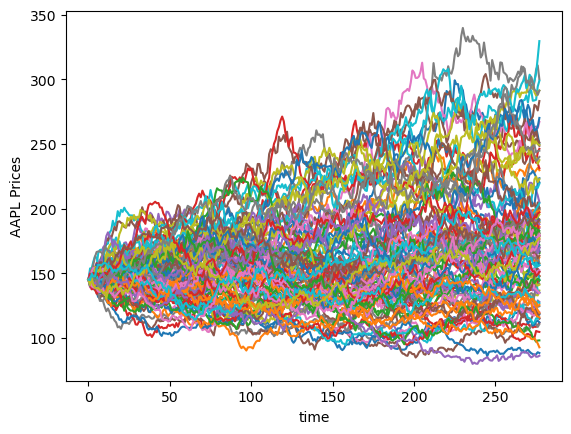

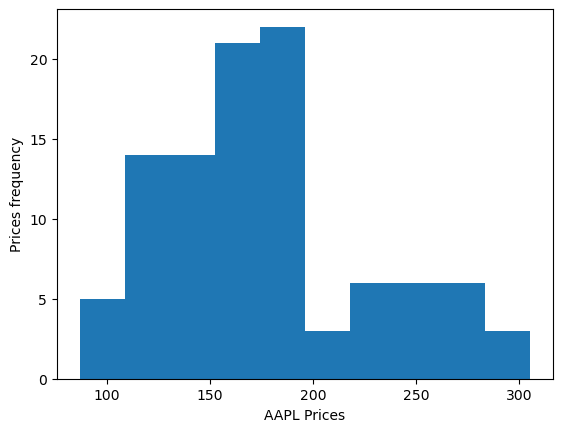

In [35]:
from scipy.stats import norm
SEED = np.random.seed(0) 
def generate_prices_from_GBM_model(prices_data):
    log_returns = np.log(1 + prices_data.pct_change())
    log_returns = log_returns.dropna()
    u = log_returns.mean()
    var = log_returns.var()
    
    drift = u - (0.5*var)
    stdev = log_returns.std()
    days = 278
    trials = 100
    Z = norm.ppf(np.random.rand(days, trials)) 
    daily_returns = np.exp(drift + stdev * Z)
    price_paths = np.zeros_like(daily_returns)
    price_paths[0] = prices_data.iloc[1]
    for t in range(1, days):
        price_paths[t] = price_paths[t-1]*daily_returns[t]
    return price_paths
        
# test_prices = total_stock_prices["AAPL"].iloc[-253:]
generated_stock_prices = {stock: generate_prices_from_GBM_model(total_stock_prices[stock].iloc[-279:]) for stock in stocks_list}
import matplotlib.pyplot as plt
plt.plot(generated_stock_prices["AAPL"])
plt.xlabel("time")
plt.ylabel("AAPL Prices")
plt.show()

plt.hist(generated_stock_prices["AAPL"][251, :], bins=10)
plt.xlabel("AAPL Prices")
plt.ylabel("Prices frequency")
plt.show()

# Distribution of Sharpe Ratios and Deflated Sharpe Ratio

First we prepare the data for 100 trials. Then we calculate the sharpe ratios for the baseline buy and hold strategy. Finally we construct the labeled predictions for the toy investmentt strategy and calculate the distribution of its Sharpe Ratios

In [36]:
def prepare_trials_data(generated_stock_prices_data):
    trials_data = {}
    for trial in range(0, 100):
        portfolio_data = {stock: generated_data[:, trial] for stock, generated_data in generated_stock_prices_data.items()}
        trials_data[trial] = pd.DataFrame(portfolio_data)
    return trials_data

trials_prices = prepare_trials_data(generated_stock_prices)
trials_prices[99]

,AAPL,AMZN,GOOGL,BRK-B,UNH,XOM,WMT,LIN,UPS,NEE,PLD
0,145.272552,124.790001,116.820503,312.149994,481.713745,95.536621,122.889175,330.521576,180.655411,78.387077,123.521233
1,144.943222,123.678100,118.214122,306.606525,493.604163,99.125933,122.384030,329.464622,181.992429,79.097856,122.763255
2,149.923013,125.259426,118.949266,310.807737,487.363368,101.481095,124.982574,325.649895,183.140630,78.309618,123.754231
3,147.551498,123.656020,121.413471,305.177751,481.404260,100.116374,122.186604,325.043559,184.617450,78.943035,125.720399
4,147.713505,121.934405,126.319492,307.046992,490.414112,102.103722,122.078419,335.596908,183.880272,79.702216,126.606277
...,...,...,...,...,...,...,...,...,...,...,...
273,157.904983,149.376060,130.205179,367.079700,529.947743,97.657589,162.301036,311.852667,270.872913,81.397212,107.304812
274,155.910035,146.252741,125.382536,369.950771,526.453410,97.870942,162.533935,309.407708,271.314297,80.161183,103.715452
275,158.722471,145.941955,129.594903,361.459858,526.281871,97.750763,161.266820,312.145621,267.187226,82.203619,102.862196
276,155.449488,144.342421,132.230031,362.200158,523.528909,98.644134,159.988705,311.872038,270.336929,79.631691,105.696353


## Buy and Hold Sharpe Ratios (SR)

In [37]:
# print(trials_prices)
SR_trials ={trial: buy_and_hold(trials_prices[trial], last_non_test_day_prices, optimum_portfolio, 252) for trial in trials_prices}
SR_trials

{0: 2.5842577345654885,
 1: 0.04416371847045061,
 2: 0.21311021345867828,
 3: -0.4617740038596667,
 4: 1.1814887769580285,
 5: 2.4340318213649823,
 6: 1.3428800939215106,
 7: 1.9564046027647901,
 8: 2.0136925736002365,
 9: -0.5225906445674517,
 10: -0.9371750643523497,
 11: 0.28681570334790746,
 12: -0.25684498001719874,
 13: 1.5770414327770608,
 14: -0.21699527701966706,
 15: -0.8865422795645406,
 16: 1.1692655493399984,
 17: 1.0090478037084525,
 18: 0.3049085434559993,
 19: 1.0152444026374927,
 20: -0.3090122598303591,
 21: 1.4857228386164678,
 22: -0.8340757645901143,
 23: 1.5626946841291909,
 24: 0.2578468141635,
 25: 0.36590120817713373,
 26: 1.1298915064013573,
 27: 2.074991119619249,
 28: 1.4370955454170817,
 29: 1.9276581136608277,
 30: 1.7926657642949637,
 31: 0.1804848912283491,
 32: -0.9806772397574542,
 33: 1.6087763410004197,
 34: 1.374591910725865,
 35: 0.38233452576093524,
 36: 0.2990651212914593,
 37: 0.39440914791781867,
 38: 1.8478392034776312,
 39: -0.016899405436790

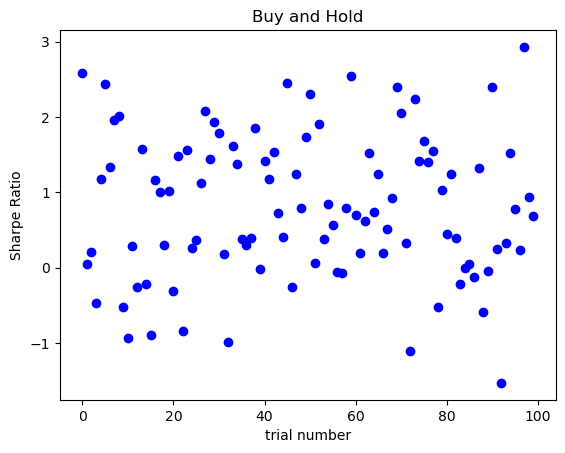

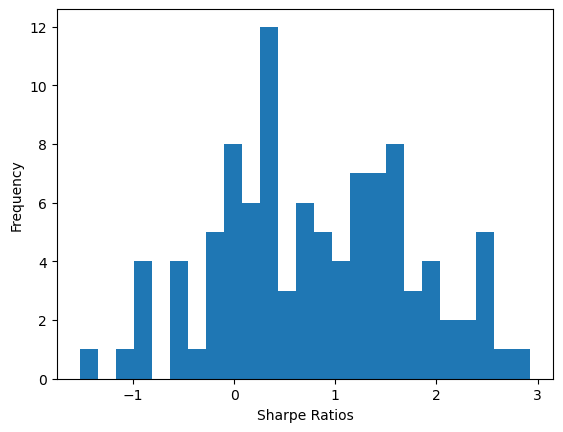

In [38]:
import matplotlib.pyplot as plt
plt.plot(list(SR_trials.values()), "bo")
plt.title("Buy and Hold")
plt.xlabel("trial number")
plt.ylabel("Sharpe Ratio")
plt.show()

plt.hist(list(SR_trials.values()), bins=25)
plt.xlabel("Sharpe Ratios")
plt.ylabel("Frequency")
plt.show()

In [39]:
SR_trials_list = list(SR_trials.values())
mean_SR = np.mean(SR_trials_list)
print("buy and hold mean SR:", mean_SR)
np.std(SR_trials_list)
var_SR = np.var(SR_trials_list)
print("buy and hold variance SR:", var_SR)

buy and hold mean SR: 0.805229357997286
buy and hold variance SR: 0.9018581952530356


In [40]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
%matplotlib inline

# universal constants
gamma = 0.5772156649015328606
e = np.exp(1)

# analytical formula for expected maximum sharpe ratio
def approximate_expected_maximum_sharpe(mean_sharpe, var_sharpe, nb_trials):
    return mean_sharpe + np.sqrt(var_sharpe) * (
        (1 - gamma) * norm.ppf(1 - 1 / nb_trials) + gamma * norm.ppf(1 - 1 / (nb_trials * e)))


def compute_deflated_sharpe_ratio(estimated_sharpe,
                                  sharpe_variance,
                                  nb_trials,
                                  backtest_horizon,
                                  skew,
                                  kurtosis):
    SR0 = approximate_expected_maximum_sharpe(0, sharpe_variance, nb_trials)
    print("Expected Maximum Sharpe Ratio:", SR0)
    
    return norm.cdf(((estimated_sharpe - SR0) * np.sqrt(backtest_horizon - 1)) 
                    / np.sqrt(1 - skew * estimated_sharpe + ((kurtosis - 1) / 4) * estimated_sharpe**2))
                              

                              
DSR = compute_deflated_sharpe_ratio(estimated_sharpe=mean_SR / np.sqrt(252),
                              sharpe_variance=var_SR / 252,
                              nb_trials=100,
                              backtest_horizon=252,
                              skew=0.24955301000940763,
                              kurtosis=1.2515229507334853
                             )
print("buy and hold deflated SR:", DSR)

Expected Maximum Sharpe Ratio: 0.15138849023851014
buy and hold deflated SR: 0.05426076798625315


This tells us that there is only about a 5% chance that buy and and hoold strategy will give a positive sharpe ratio. Buy playing around with different values, we find that the high variance in the sharpe ratios strongly determines whether there will be a high or low probability of a non-zero SR.

## Toy investment strategy Sharpe Ratios (SR)

Now we perform a similar analysis to computed the deflated sharpe ratio for the toy investment strategy. We begin by using our best fit models to predict all the labels for the trial prices.

In [41]:
labeled_trials ={trial:predicted_labels_per_stock(stocks_list, trials_prices[trial], stocks_fitted_models, stocks_test_data) for trial in trials_prices}
labeled_trials[99]

,index,AAPL,AMZN,GOOGL,BRK-B,UNH,XOM,WMT,LIN,UPS,...,WMT_label,WMT_probs,LIN_label,LIN_probs,UPS_label,UPS_probs,NEE_label,NEE_probs,PLD_label,PLD_probs
0,25,156.957726,139.578355,136.407378,322.068574,515.866288,101.170878,124.269667,348.341042,188.617423,...,1,0.376617,2,0.359512,2,0.363236,2,0.477525,2,0.377701
1,26,152.932930,132.671842,137.798802,320.273292,513.151731,103.419795,122.726448,349.841466,191.449875,...,1,0.347146,1,0.340273,1,0.372569,2,0.439882,2,0.351740
2,27,152.722905,129.730042,143.867593,320.512886,513.079740,99.862878,125.356420,348.983135,195.992738,...,2,0.381967,1,0.342502,2,0.378220,2,0.358606,2,0.370523
3,28,151.609947,129.153900,141.611172,320.946673,510.909366,97.693437,124.503958,343.588742,191.138241,...,1,0.371865,2,0.359091,2,0.409147,2,0.385434,2,0.365941
4,29,153.210200,128.559319,138.087867,318.986536,506.986123,99.560525,126.624590,347.082376,193.647299,...,2,0.376149,2,0.364371,0,0.376078,2,0.413216,2,0.359643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,273,157.904983,149.376060,130.205179,367.079700,529.947743,97.657589,162.301036,311.852667,270.872913,...,1,0.392356,2,0.399388,1,0.391188,2,0.414992,2,0.390235
249,274,155.910035,146.252741,125.382536,369.950771,526.453410,97.870942,162.533935,309.407708,271.314297,...,1,0.400209,2,0.378052,1,0.402525,1,0.370147,2,0.384859
250,275,158.722471,145.941955,129.594903,361.459858,526.281871,97.750763,161.266820,312.145621,267.187226,...,1,0.342597,2,0.393106,2,0.375612,2,0.355054,2,0.377463
251,276,155.449488,144.342421,132.230031,362.200158,523.528909,98.644134,159.988705,311.872038,270.336929,...,1,0.349269,2,0.397634,1,0.403484,1,0.374014,2,0.363011


In [42]:
strategy_trials ={trial: sell_and_rebalance(labeled_trials[trial], total_stock_prices, 252) for trial in trials_prices}
strategy_trials

{0: 2.7554752180960738,
 1: 0.24341331931271168,
 2: 0.28549582041967797,
 3: -0.73429922446838,
 4: 1.1470109503885686,
 5: 2.2815880090500857,
 6: 1.0061998766863869,
 7: 2.2733457989289203,
 8: 1.801905524385539,
 9: -0.5358463494293099,
 10: -0.7456933176679298,
 11: 0.20679484602278886,
 12: -0.13296057185197555,
 13: 1.9938307242197963,
 14: -0.1755811967623899,
 15: -0.9822318146542263,
 16: 1.4782867103348456,
 17: 1.3521004940666426,
 18: 0.002866754375701646,
 19: 0.41835615137959137,
 20: -0.2835665180610355,
 21: 1.6649594463139665,
 22: -0.6021244897931345,
 23: 1.5020589188487283,
 24: -0.7240078297735398,
 25: 0.24620558688304753,
 26: 0.7053038930346701,
 27: 1.8764738569692172,
 28: 1.4318911702979036,
 29: 1.8849856330721066,
 30: 1.7611455296392193,
 31: 0.2936191849452504,
 32: -1.116251288550319,
 33: 1.4598929109526786,
 34: 1.4990377348729356,
 35: 0.3329800432380298,
 36: -0.012729811433788008,
 37: 0.07804860953383458,
 38: 1.8267681790362484,
 39: -0.048542974

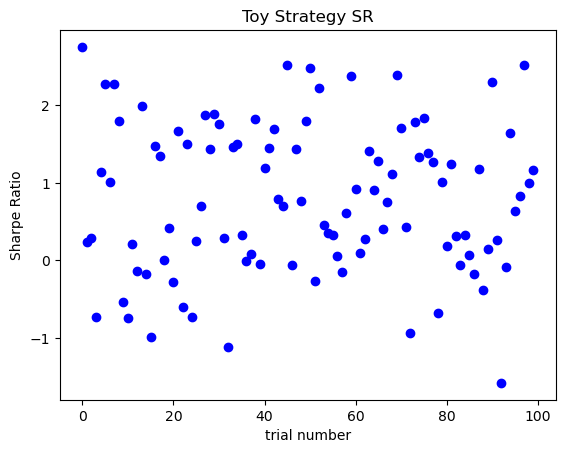

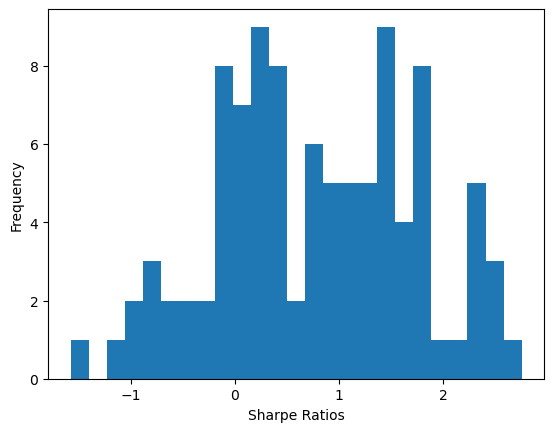

In [43]:
import matplotlib.pyplot as plt
strategy_trials_list = list(strategy_trials.values())
plt.plot(strategy_trials_list, "bo")
plt.title("Toy Strategy SR")
plt.xlabel("trial number")
plt.ylabel("Sharpe Ratio")
plt.show()

plt.hist(strategy_trials_list, bins=25)
plt.xlabel("Sharpe Ratios")
plt.ylabel("Frequency")
plt.show()

In [44]:
strategy_trials_list = list(strategy_trials.values())
mean_SR = np.mean(strategy_trials_list)
print("Toy Strategy mean SR:", mean_SR)
np.std(strategy_trials_list)
var_SR = np.var(strategy_trials_list)
print("Toy variance SR:", var_SR)

Toy Strategy mean SR: 0.7880164245971063
Toy variance SR: 0.9189772198247538


In [45]:
DSR = compute_deflated_sharpe_ratio(estimated_sharpe=mean_SR / np.sqrt(252),
                              sharpe_variance=var_SR / 252,
                              nb_trials=100,
                              backtest_horizon=252,
                              skew=0.24955301000940763,
                              kurtosis=1.2515229507334853
                             )
print("Toy Strategy deflated SR:", DSR)

Expected Maximum Sharpe Ratio: 0.15281855992243282
Toy Strategy deflated SR: 0.05001162255236554


We find that the strategy performs as badly as the buy and hold strategy, if not worse, with a very low deflated SR.